In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mesh = fn.Mesh('geo.xml')
subdomains = fn.MeshFunction("size_t", mesh,'geo_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh,'geo_facet_region.xml')

In [3]:
V = fn.FunctionSpace(mesh, 'P', 2)
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
V0 = fn.FunctionSpace(mesh, 'DG', 0)

In [4]:
inner_boundary = fn.DirichletBC(V, fn.Constant(15.0), boundaries, 3)
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 4)
bcs =[inner_boundary, outer_boundary]

In [5]:
eps_r = 10 # dielectric particle 유전율을 의미한다.

'''아래의 class는 subdomain을 바탕으로 유전율을 결정하게 된다.
앞서 gmsh를 사용해서 subdomain에서 dielectric particle를 physical에서 2로 지정했다.
따라서 이에 해당하는 지점은 dielectric particle 유전율이 된다.
그 외의 지점 vacuum의 경우 유전율이 1이 된다.'''

class permittivity(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 2:
            values[0] = eps_r
        else:
            values[0] = 1

eps = permittivity(subdomains, degree=2)

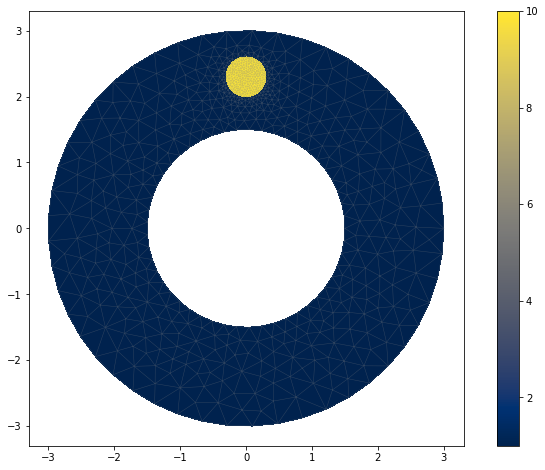

In [6]:
#위 코드에서 설정한 유전율의 시각화
plt.figure(figsize=(12,8))
fn.plot(mesh, linewidth=0.5, alpha=0.35)
p = fn.plot(fn.project(eps, V0), cmap='cividis')
plt.colorbar(p)
plt.show()

In [7]:
u = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(u), fn.grad(v)) * eps * fn.dx #기존의 경우 eps를 1로 고정하였으나 Subdomain에서 위치에 따라서 변경
L = fn.Constant('0') * v * fn.dx
u = fn.Function(V)
fn.solve(a == L, u, bcs)

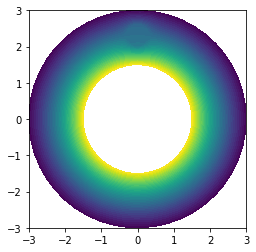

In [8]:
fn.plot(u)

In [9]:
electric_field = fn.project(-fn.grad(u))

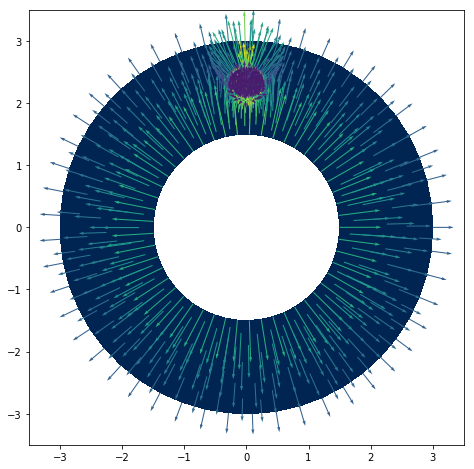

In [10]:
#electric_field의 시각화
plt.figure(figsize=(12,8))
fn.plot(fn.project(eps, V), cmap='cividis')
p = fn.plot(electric_field, scale=150)
#plt.colorbar(p)
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
# plt.savefig('images/output/electric_field.png', bbox_inches='tight')
plt.show()

In [11]:
potentialFile = fn.File('output/potential-particles.pvd')
potentialFile << u

vtkfile = fn.File('output/e_field-particles.pvd')
vtkfile << electric_field